# CRM Analysis

## Table of Contents
1. [Objective](#objective)
2. [Business Objective](#business-objective)
3. [Data Loading and Preprocessing](#data-preprocessing)
4. [Exploratory Data Analysis (EDA)](#eda)
5. [RFM Analysis](#rfm-analysis)
6. [Cohort Analysis](#cohort-analysis)
7. [Model Building](#model-building)

<a id='objective'></a>
## Objective
The objective of this analysis is to understand the behavior of the customers which will in turn help the business to strategize its plans in order to retain and acquire customers.

<a id='business-objective'></a>
## Business Objective
The business objective is to increase customer retention and overall profitability. This can be achieved by understanding customer behavior and implementing strategies that encourage repeat purchases and customer loyalty.

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the data
data = pd.read_csv('data.csv')

# Display the first few rows of the dataframe
data.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 79780: invalid start byte

In [ ]:
# Load the data with 'ISO-8859-1' encoding
data = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
data.head()

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

In [ ]:
# Dropping rows with missing 'CustomerID'
data = data.dropna(subset=['CustomerID'])

# Filling missing 'Description' with 'Unknown'
data['Description'].fillna('Unknown', inplace=True)

# Check if there are any missing values left
data.isnull().sum()

In [ ]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Check data types of all columns
data.dtypes

In [ ]:
# Basic statistics
data.describe(include='all')

ValueError: mixed datetimes and integers in passed array

In [ ]:
# Basic statistics for numerical variables
data.describe()

In [ ]:
# Basic statistics for categorical variables
data.describe(include=['object'])

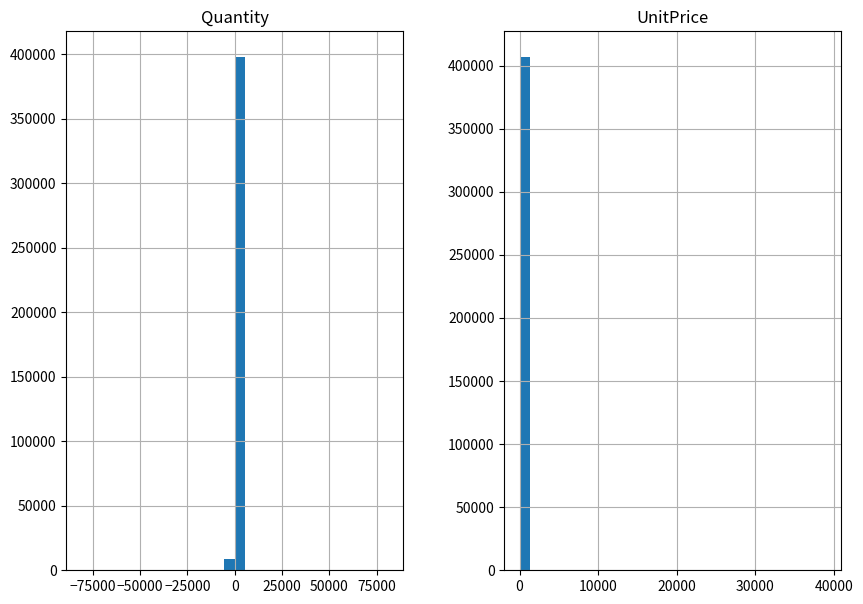

In [ ]:
# Plotting histograms for numerical variables
data[['Quantity', 'UnitPrice']].hist(bins=30, figsize=(10, 7))
plt.show()

In [ ]:
# RFM Analysis

# Monetary
data['TotalSum'] = data['Quantity']*data['UnitPrice']
monetary = data.groupby('CustomerID')['TotalSum'].sum()
monetary = monetary.reset_index()

# Frequency
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()

# Merge monetary and frequency
mf = pd.merge(monetary, frequency, on='CustomerID')

# Recency
maximum = max(data['InvoiceDate'])
data['Diff'] = maximum - data['InvoiceDate']
recency = data.groupby('CustomerID')['Diff'].min()
recency = recency.reset_index()

# Merge recency with monetary and frequency
rfm = pd.merge(mf, recency, on='CustomerID')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']

# Convert Recency to just number of days
rfm['Recency'] = rfm['Recency'].dt.days

rfm.head()

In [ ]:
# Cohort Analysis

# Create a column 'InvoiceMonth' by truncating the 'InvoiceDate' to month
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

# Create a 'CohortMonth' column by grouping data by 'CustomerID' and selecting the 'InvoiceMonth' for the first invoice
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')

# Define a function to extract year, month and day integer values
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the 'InvoiceMonth' and 'CohortMonth' columns
invoice_year, invoice_month, _ = get_date_int(data, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
data['CohortIndex'] = years_diff * 12 + months_diff + 1

data.head()

In [ ]:
# Create a pivot table with 'CohortMonth' as rows, 'CohortIndex' as columns, and the count of unique 'CustomerID's as values
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_count

In [ ]:
# Calculate the retention rate
cohort_sizes = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_sizes, axis=0)

# Convert the retention rate to percentage for better readability
retention.round(3) * 100

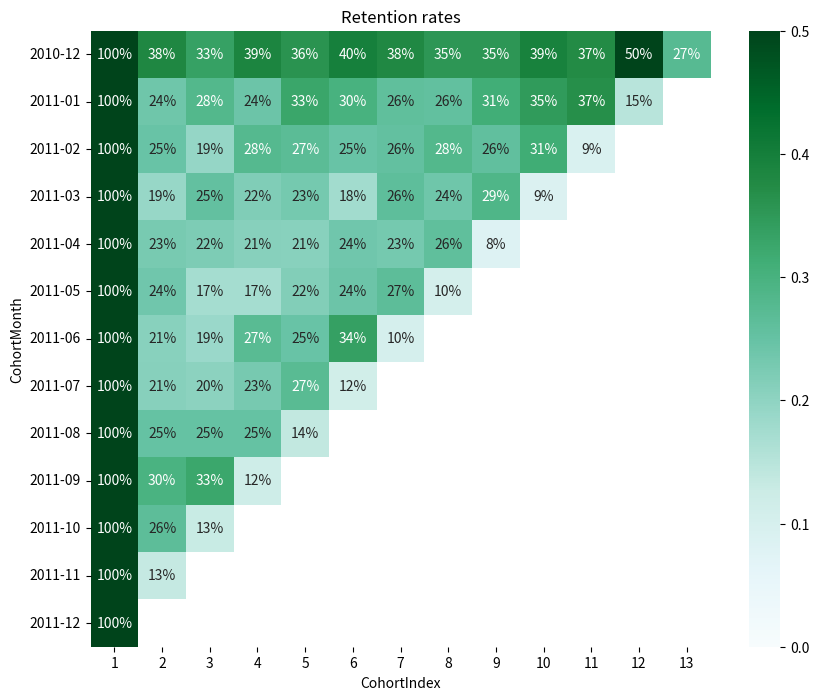

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure instance and set the size of the figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.title('Retention rates')
plt.show()

In [ ]:
# Check for missing values in the RFM data
rfm.isnull().sum()

In [ ]:
# Identify outliers in the 'Monetary' column
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Monetary'] >= Q1 - 1.5*IQR) & (rfm['Monetary'] <= Q3 + 1.5*IQR)]

# Identify outliers in the 'Frequency' column
Q1 = rfm['Frequency'].quantile(0.25)
Q3 = rfm['Frequency'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Frequency'] >= Q1 - 1.5*IQR) & (rfm['Frequency'] <= Q3 + 1.5*IQR)]

# Identify outliers in the 'Recency' column
Q1 = rfm['Recency'].quantile(0.25)
Q3 = rfm['Recency'].quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm['Recency'] >= Q1 - 1.5*IQR) & (rfm['Recency'] <= Q3 + 1.5*IQR)]

rfm.shape

(3697, 4)

In [ ]:
# Import the necessary library
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Fit and transform the RFM data
rfm_scaled = scaler.fit_transform(rfm)

# Convert the scaled data into a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()

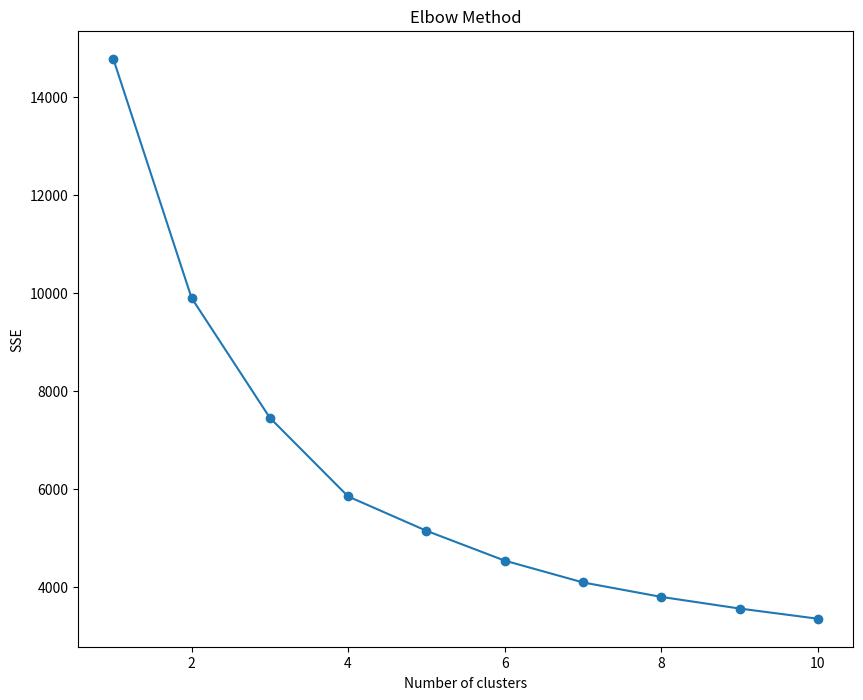

In [ ]:
# Import the necessary libraries
from sklearn.cluster import KMeans

# Create an empty list to store the SSE (Sum of Squared Errors) for each number of clusters
sse = []

# Iterate over a range of desired clusters
for k in range(1, 11):
    # Create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)

    # Fit the scaled data
    kmeans.fit(rfm_scaled)

    # Append the SSE for k clusters to the sse list
    sse.append(kmeans.inertia_)

# Plot the SSE for each number of clusters
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Create a KMeans instance with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)

# Fit the scaled data and predict the cluster labels
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Assign the cluster labels to the original RFM data
rfm['Cluster'] = cluster_labels

# Calculate the mean RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').mean()

cluster_avg

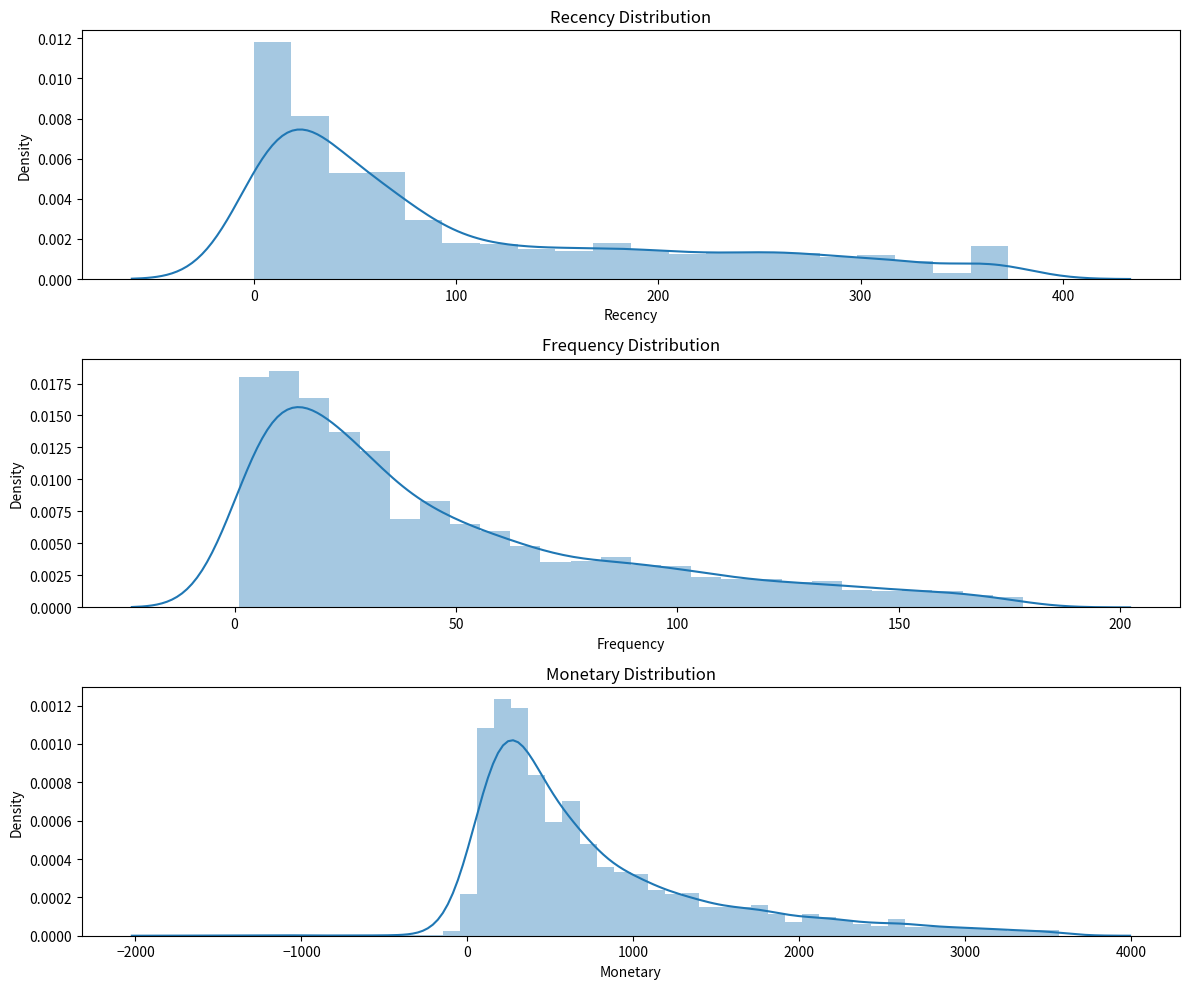

In [ ]:
# Plotting distributions of Recency, Frequency, and Monetary values
plt.figure(figsize=(12,10))

# Recency distribution plot
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
plt.title('Recency Distribution')

# Frequency distribution plot
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
plt.title('Frequency Distribution')

# Monetary distribution plot
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Fit and transform the data
rfm_scaled = scaler.fit_transform(rfm)

# Convert the scaled data into a DataFrame
rfm_scaled = pd.DataFrame(data=rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()

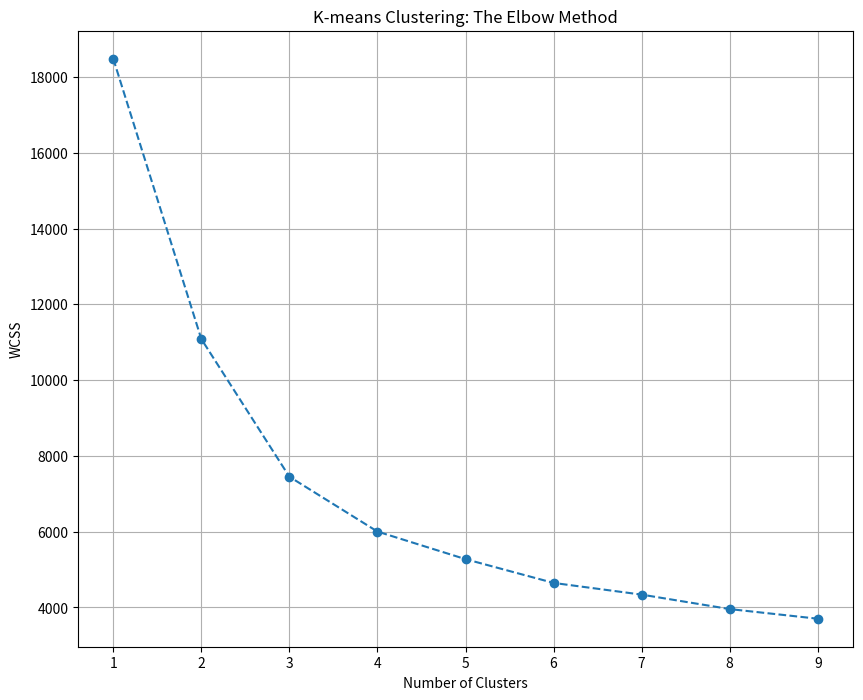

In [ ]:
# Import necessary libraries
from sklearn.cluster import KMeans

# Define a range of clusters
clusters_range = range(1, 10)

# Initialize an empty list to store the WCSS for each K value
wcss = []

# Run KMeans for each K value and calculate the WCSS
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each K value
plt.figure(figsize=(10, 8))
plt.plot(clusters_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering: The Elbow Method')
plt.grid(True)
plt.show()

In [ ]:
# Initialize a KMeans instance with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

# Fit the model to the scaled RFM data
kmeans.fit(rfm_scaled)

# Assign the cluster labels to each customer
cluster_labels = kmeans.labels_

# Add the cluster labels to the original RFM data
rfm['Cluster'] = cluster_labels

rfm.head()

           CustomerID     Monetary   Frequency     Recency
Cluster                                                   
0        15183.916773  1848.741474  109.980794   43.261204
1        15315.881417   560.264565   34.182238   51.746407
2        15390.408058   326.928626   20.674587  255.381198


<Figure size 1000x800 with 0 Axes>

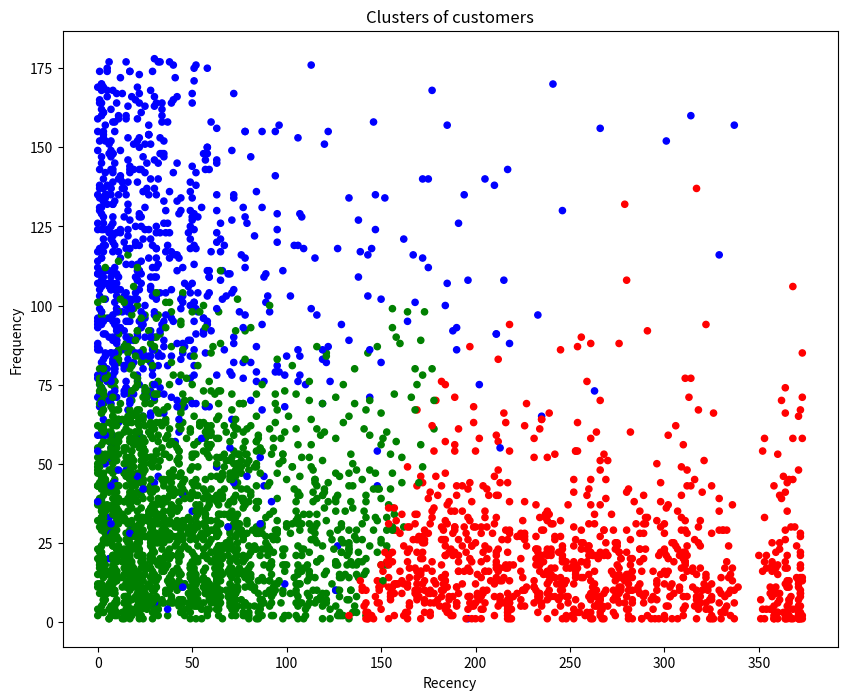

In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = rfm.groupby(['Cluster']).mean()

# Print the average RFM values
print(cluster_avg)

# Plot the clusters
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r']
rfm['Color'] = rfm['Cluster'].map(lambda p: colors[p])
ax = rfm.plot(kind='scatter', x='Recency', y='Frequency', figsize=(10,8), c=rfm['Color'])
plt.title('Clusters of customers')
plt.show()

In [ ]:
# Import necessary libraries
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)

# Print the silhouette score
print('Silhouette Score: ', silhouette_avg)

Silhouette Score:  0.41410713974500607
